In [1]:
from synthetic_data_generator import create_synthetic_matrix, create_synthetic_data
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

# Hierarchichal training

In our case we can make problem gradually more difficult to solve, while keeping the the `A` matrix in exactly the same shape. This should allow us to use the same `ResGCN`

- First way is to increase the scale of the filter, as the bigger scacle the worse is the conditioning of the matrix. 
- Second is increasing the order of the filer `n`, which makes much more difficult to solve the problem
---

To start we have to generate sythetic problem of given size

In [2]:
Lx = 1000 # Size of domain in km
dxm = 2 # Mesh resolution in km
n2d = np.arange(0, Lx + 1, dxm, dtype="float32").shape[0]**2 # Number of mesh nodes

ss, ii, jj, tri, xcoord, ycoord = create_synthetic_matrix(Lx, dxm, False)
tt = create_synthetic_data(Lx, dxm)

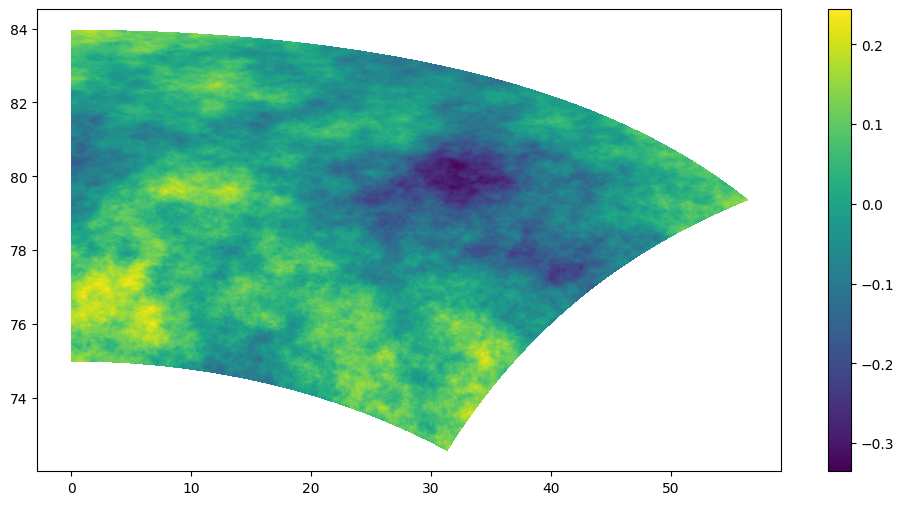

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

Now lets define model parameters 

In [4]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

Now we need to create scales that we want to use

In [5]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km

In [6]:
tt.shape

(251001,)

Now we define the matricies for model to learn preconditioning

In [7]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

/tmp/ipykernel_3763960/641305269.py:9: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)


Now model can be initialized for the first phase of training

In [8]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

As a test we will solve the problem without preconditioner 

In [9]:
iterations = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=19999, progress_bar=True)
    print("Iteration " + str(iters))
    iterations[i] = iters

Solve:   1%|          | 137/19999 [00:00<00:52, 377.44it/s]


Iteration 137


Solve:   2%|▏         | 349/19999 [00:00<00:35, 556.32it/s]


Iteration 349


Solve:   5%|▍         | 928/19999 [00:01<00:33, 576.03it/s]


Iteration 928


Solve:  13%|█▎        | 2515/19999 [00:04<00:30, 581.54it/s]


Iteration 2515


Solve:  35%|███▌      | 7083/19999 [00:12<00:22, 581.77it/s]


Iteration 7083


Solve:  98%|█████████▊| 19622/19999 [00:33<00:00, 583.27it/s]


Iteration 19622


Solve: 100%|██████████| 19999/19999 [00:34<00:00, 583.39it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:34<00:00, 583.55it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:34<00:00, 582.90it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:34<00:00, 582.74it/s]

Iteration 19999


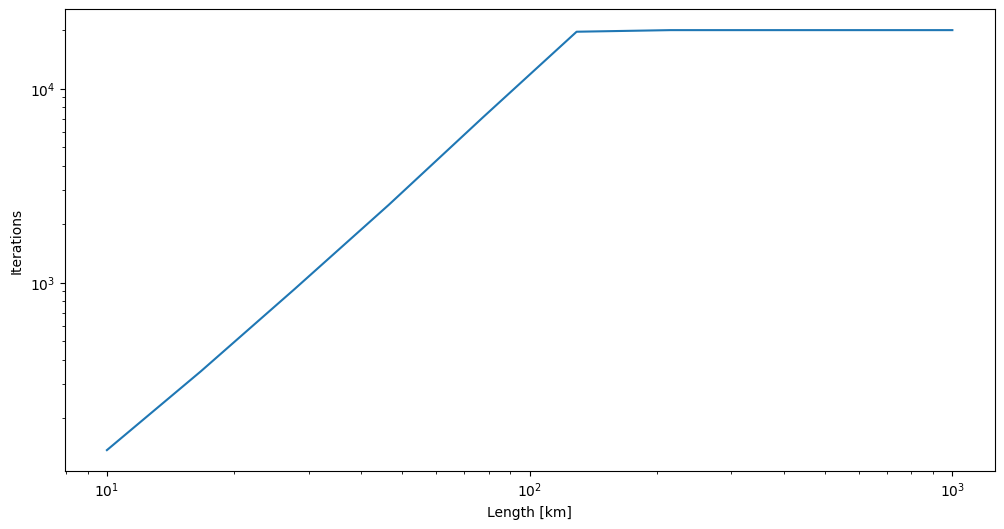

In [10]:
plt.plot(np.logspace(1, 3, 10), iterations)
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")

In [11]:
#OPTUNA 

In [12]:
%pip install optuna
%pip install --upgrade jupyter jupyterlab notebook


/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
### OPTUNA AND TASK 1&2 First Try

### How to vary phases and vary A(s)

In [14]:
# === Cell 1: Optuna objective with Tasks 1&2 (fixed 8 phases, FAST) ===
import gc, time, optuna
from optuna.pruners import MedianPruner
import torch
import torch.nn.functional as F

def _free_cuda():
    torch.cuda.empty_cache(); gc.collect()

def _dtype_from_name(name: str):
    return torch.float64 if "64" in name else torch.float32

# Choose GROWTH
_GROWTH_E = 1.06
_GROWTH_M = 1.06
_GROWTH_B = 1.06

# Choose PHASES and EPOCHS and _AS_SUBSET for variaton
# NOT included in hyperparameter tuning, as significant computation time increase for non-guaranteed speed-up
# each phase trains on the first _AS_SUBSET graphs; set _AS_SUBSET = len(As) to use all graphs each phase
_AS_SUBSET = 2
_MAX_PHASES = 2         
_CAP_EPOCHS = 200         
_CAP_M      = 80        
_CAP_BATCH  = 4          


def objective(trial: optuna.Trial):
    # Vary ALL
    num_layers_          = trial.suggest_int("num_layers", 4, 16, step=2)
    embed_               = trial.suggest_categorical("embed", [16, 32, 48, 64])
    hidden_              = trial.suggest_categorical("hidden", [64, 96, 128, 192, 256])
    drop_rate_           = trial.suggest_float("drop_rate", 0.0, 0.4, step=0.05)
    disable_scale_input_ = trial.suggest_categorical("disable_scale_input", [False, True])
    dtype_name_          = trial.suggest_categorical("dtype", ["float32", "float64"])
    lr_                  = trial.suggest_float("lr", 5e-4, 5e-3, log=True)
    weight_decay_        = trial.suggest_float("weight_decay", 0.0, 1e-2, log=False)  # allow exact 0
    training_data_       = trial.suggest_categorical("training_data", ["x_mix", "x_subspace", "x_random"])
    m_                   = trial.suggest_int("m", 20, 80, step=10)
    batch_size_          = trial.suggest_categorical("batch_size", [1, 2, 4])
    grad_accu_steps_     = trial.suggest_categorical("grad_accu_steps", [1, 2, 4])
    epochs_              = trial.suggest_int("epochs", 60, 200)  # serves as BASE epochs
    phases_              = trial.suggest_int("phases", 1, _MAX_PHASES)
    dtype_ = _dtype_from_name(dtype_name_)

    # keep float64 trials lighter (CHATGPT)
    if dtype_ == torch.float64:
        m_ = min(m_, 40)
        batch_size_ = min(batch_size_, 2)

    # build model once in the sampled dtype; init on smallest graph
    A0 = As[0]
    net = ResGCN(
        A0,
        num_layers=num_layers_, embed=embed_, hidden=hidden_,
        drop_rate=drop_rate_, scale_input=(not disable_scale_input_), dtype=dtype_
    ).to(device).to(dtype_)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr_, weight_decay=weight_decay_)

    M_tune = GNP(A0, training_data_, m_, net, device)
    if hasattr(M_tune, "dtype"):
        M_tune.dtype = dtype_

    best_overall = float("inf")
    pruner_step = 0

    try:
        # Tasks 1&2: vary phases and subsets, each phase varies over _AS_SUBSET=K graphs which can be changed 
        total_phases = _MAX_PHASES
        As_fast = As[:min(_AS_SUBSET, len(As))]

        for phase in range(total_phases):
            # per-phase growth from the *trial* bases, then clamp to caps
            epochs_now = int(round(epochs_     * (_GROWTH_E ** phase)))
            m_now      = int(round(m_          * (_GROWTH_M ** phase)))
            batch_now  = int(round(batch_size_ * (_GROWTH_B ** phase)))

            epochs_now = max(1, min(_CAP_EPOCHS, epochs_now))
            M_tune.m   = max(1, min(_CAP_M,     m_now))
            batch_now  = max(1, min(_CAP_BATCH, batch_now))

            for i, Ai in enumerate(As_fast):
                M_tune.A = Ai

                # no checkpointing during search to keep trials light
                hist_loss, best_loss, best_epoch, _ = M_tune.train(
                    batch_size=batch_now,
                    grad_accu_steps=grad_accu_steps_,
                    epochs=epochs_now,
                    optimizer=optimizer,
                    scheduler=None,
                    num_workers=0,
                    checkpoint_prefix_with_path=None,
                    progress_bar=False,
                )

                metric = float(best_loss) if len(hist_loss) else float('inf')
                best_overall = min(best_overall, metric)

                pruner_step += 1
                trial.report(metric, pruner_step)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

        return best_overall

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            _free_cuda()
            raise optuna.exceptions.TrialPruned() from e
        raise
    finally:
        del net, optimizer, M_tune
        _free_cuda()


In [15]:
# Cell 2: Study setup (safe seeding) + globals update (+schedule) 
sampler = optuna.samplers.TPESampler(n_startup_trials=10, multivariate=True, group=True)
pruner  = MedianPruner(n_warmup_steps=2)

study = optuna.create_study(
    study_name="gnp_hparam_search",
    direction="minimize",
    sampler=sampler,
    pruner=pruner,
    # storage="sqlite:///gnp_optuna.db", load_if_exists=True,
)

# SAFE SEED VALUES (use existing if present, else defaults) 
seed_epochs = int(min(120, int(globals().get("_CAP_EPOCHS", 200))))
seed_phases = int(globals().get(1, _MAX_PHASES))

# seed with current globals + safe schedule seeds
study.enqueue_trial({
    "num_layers": num_layers,
    "embed": embed,
    "hidden": hidden,
    "drop_rate": drop_rate,
    "disable_scale_input": disable_scale_input,
    "dtype": "float64" if dtype == torch.float64 else "float32",
    "lr": lr,
    "weight_decay": weight_decay,
    "training_data": training_data,
    "m": m,
    "batch_size": batch_size,
    "grad_accu_steps": grad_accu_steps,
    "epochs": seed_epochs,  
    "phases": seed_phases,  
})

# choose amount of trials
study.optimize(objective, n_trials=12, gc_after_trial=True, show_progress_bar=True)

print(f"\n[Optuna] Trials: {len(study.trials)}  Best value: {study.best_value:.6e}")
print("[Optuna] Best hyperparameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

best = study.best_trial.params

# Update core 
num_layers = int(best["num_layers"])
embed = int(best["embed"])
hidden = int(best["hidden"])
drop_rate = float(best["drop_rate"])
disable_scale_input = bool(best["disable_scale_input"])
dtype = torch.float64 if best["dtype"] == "float64" else torch.float32
lr = float(best["lr"])
weight_decay = float(best["weight_decay"])
training_data = str(best["training_data"])
m = int(best["m"])
batch_size = int(best["batch_size"])
grad_accu_steps = int(best["grad_accu_steps"])

# Export schedule knobs for the training cell
# Use tuned 'epochs' and 'phases' if present; otherwise keep the seed values.
PHASES = int(best.get("phases", seed_phases))
EPOCHS_PER_PHASE_BASE = int(best.get("epochs", seed_epochs))
M_BASE = int(best.get("m", m))
BATCH_BASE = int(best.get("batch_size", batch_size))

# Keep these consistent with Cell 1 FAST settings:
GROWTH_EPOCHS = 1.06
GROWTH_M = 1.06
GROWTH_BATCH = 1.06
MAX_EPOCHS_PER_PHASE = 40
MAX_M = 512
MAX_BATCH = 4

# Runtime knobs used by the training cell
CKPT_DIR = "./checkpoints_tasks12"
SAVE_BEST_EACH_PASS = True
RESUME_FROM_PHASE = 0

print("\n[Optuna] Globals updated (+schedule).")
print(f"[Schedule] PHASES={PHASES}, EPOCHS_BASE={EPOCHS_PER_PHASE_BASE}, "
      f"M_BASE={M_BASE}, BATCH_BASE={BATCH_BASE}, "
      f"GROWTH(E,M,B)=({GROWTH_EPOCHS},{GROWTH_M},{GROWTH_BATCH}), "
      f"MAX(E,M,B)=({MAX_EPOCHS_PER_PHASE},{MAX_M},{MAX_BATCH})")



/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-07 11:12:26,787] A new study created in memory with name: gnp_hparam_search


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-10-07 11:13:04,935] Trial 0 finished with value: 0.012257604128615526 and parameters: {'num_layers': 8, 'embed': 32, 'hidden': 64, 'drop_rate': 0.05, 'disable_scale_input': False, 'dtype': 'float64', 'lr': 0.002, 'weight_decay': 0.0, 'training_data': 'x_mix', 'm': 80, 'batch_size': 4, 'grad_accu_steps': 1, 'epochs': 120, 'phases': 2}. Best is trial 0 with value: 0.012257604128615526.
[I 2025-10-07 11:14:10,228] Trial 1 finished with value: 0.0526902861893177 and parameters: {'num_layers': 6, 'embed': 32, 'hidden': 64, 'drop_rate': 0.35000000000000003, 'disable_scale_input': False, 'dtype': 'float32', 'lr': 0.0027212961800432314, 'weight_decay': 0.0017429491445768552, 'training_data': 'x_random', 'm': 60, 'batch_size': 4, 'grad_accu_steps': 1, 'epochs': 145, 'phases': 2}. Best is trial 0 with value: 0.012257604128615526.
[I 2025-10-07 11:14:40,868] Trial 2 finished with value: 0.042910005897283554 and parameters: {'num_layers': 8, 'embed': 32, 'hidden': 128, 'drop_rate': 0.25, '

During training, the preconditioner network keeps changing (e.g., dropout, batch-norm, growth), so every GMRES step “sees” a slightly different operator, that’s why the iteration counts jump around.  
By freezing it (no training, no randomness) during evaluation, GMRES gets a fixed preconditioner and can converge consistently, letting us compare progress across phases.


In [20]:
import numpy as np, torch
from contextlib import contextmanager

@contextmanager
def _frozen_preconditioner(M):
    """Temporarily freeze M (and its .net) for deterministic evaluation, then restore."""
    saved = {}

    net = getattr(M, "net", None)
    if isinstance(net, torch.nn.Module):
        saved["net_training"] = net.training
        net.eval()
        saved["req_grads"] = [p.requires_grad for p in net.parameters()]
        for p in net.parameters():
            p.requires_grad_(False)
        saved["grad_enabled"] = torch.is_grad_enabled()
        torch.set_grad_enabled(False)

    for attr in ("growth", "train_mode", "adaptive", "training"):
        if hasattr(M, attr):
            saved[attr] = getattr(M, attr)
            try:
                setattr(M, attr, False)
            except Exception:
                pass

    if hasattr(M, "set_mode"):
        saved["mode"] = getattr(M, "mode", None)
        try:
            M.set_mode("inference")
        except Exception:
            pass
    if hasattr(M, "optimizer"):
        saved["optimizer"] = M.optimizer
        M.optimizer = None

    try:
        yield M
    finally:
        if isinstance(net, torch.nn.Module):
            if saved.get("net_training", False):
                net.train()
            for p, rg in zip(net.parameters(), saved.get("req_grads", [])):
                p.requires_grad_(rg)
            torch.set_grad_enabled(saved.get("grad_enabled", True))

        for attr in ("growth", "train_mode", "adaptive", "training"):
            if attr in saved:
                try:
                    setattr(M, attr, saved[attr])
                except Exception:
                    pass
        if "mode" in saved and hasattr(M, "set_mode"):
            try:
                M.set_mode(saved["mode"])
            except Exception:
                pass
        if "optimizer" in saved:
            M.optimizer = saved["optimizer"]

def evaluate_iterations_frozen(M_live, As, data, solver, rtol=1e-6, max_iters=20000):
    """Return GMRES iteration counts using an in-place frozen M (no deepcopy)."""
    iters_arr = np.zeros(len(As), dtype=float)
    old_A = getattr(M_live, "A", None)
    with _frozen_preconditioner(M_live) as M_eval:
        for i, Ai in enumerate(As):
            if hasattr(M_eval, "A"):
                M_eval.A = Ai
            ttw = data - Ai @ data
            x, iters, *_ = solver.solve(
                A=Ai, b=ttw, rtol=rtol, max_iters=max_iters, progress_bar=False, M=M_eval
            )
            iters_arr[i] = float(iters)
    if hasattr(M_live, "A"):
        M_live.A = old_A
    return iters_arr


In [21]:
# Final Tasks 1&2 training (uses globals set by Optuna Cell 2) 
import os, time, gc, numpy as np, torch

# minimal sanity
assert 'As' in globals() and len(As) > 0
assert 'ResGCN' in globals() and 'GNP' in globals()
assert 'device' in globals()

# build model
net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device).to(dtype)

optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)
if hasattr(M, "dtype"): M.dtype = dtype

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0

# container for per-phase evaluation
if "progress_iterations" not in globals():
    progress_iterations = []

t0 = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # per-phase growth 
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    M.m        = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== PHASE {phase+1}/{PHASES} === [epochs={epochs_now}, batch={batch_now}, m={M.m}]")
    tic = time.time()

    for i, Ai in enumerate(As):
        gc.collect()
        M.A = Ai  # <-- refresh graph for this pass
        ckpt_prefix = os.path.join(CKPT_DIR, f"p{phase:04d}_Ai{i:03d}_")

        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now, grad_accu_steps, epochs_now,
            optimizer, scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=(ckpt_prefix if SAVE_BEST_EACH_PASS else None),
            progress_bar=False
        )

        # optional reload of best
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            for wpath in candidates:
                if wpath and os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    if isinstance(M.net, torch.nn.Module):
                        M.net.load_state_dict(state)
                    break

        try:
            init_loss, final_loss = float(hist_loss[0]), float(hist_loss[-1])
        except Exception:
            init_loss = final_loss = np.nan
        print(f"  Ai {i:03d} | init={init_loss:.4e}, final={final_loss:.4e}, best={float(best_loss):.4e}@{best_epoch}")
        del hist_loss, best_loss, best_epoch, model_file

    # per-phase evaluation snapshot (stable iteration counts)
    try:
        iterations_this_phase = evaluate_iterations_frozen(M, As, data, solver, rtol=1e-6, max_iters=20000)
        progress_iterations.append(iterations_this_phase)
        np.save(os.path.join(CKPT_DIR, f"iterations_phase_{phase:04d}.npy"), iterations_this_phase)
    except Exception as e:
        print(f"[eval after phase {phase}] WARNING: evaluation failed: {e}")

    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))
    print(f"[phase {phase+1}] {time.time()-tic:.2f}s")

print(f"\n[Tasks 1+2] Completed in {time.time()-t0:.2f}s.")



=== PHASE 1/2 === [epochs=40, batch=2, m=30]
  Ai 000 | init=7.9180e-03, final=5.8606e-03, best=5.7585e-03@14
  Ai 001 | init=8.1656e-03, final=8.8905e-03, best=5.4202e-03@28
  Ai 002 | init=8.6377e-03, final=6.6367e-03, best=5.1900e-03@37
  Ai 003 | init=6.1659e-03, final=5.4595e-03, best=4.7144e-03@31
  Ai 004 | init=5.9622e-03, final=5.2656e-03, best=4.2644e-03@34
  Ai 005 | init=5.1955e-03, final=5.2103e-03, best=3.0309e-03@14
  Ai 006 | init=4.8747e-03, final=4.5930e-03, best=3.3574e-03@26
  Ai 007 | init=4.5235e-03, final=5.0707e-03, best=2.7211e-03@33
  Ai 008 | init=3.9543e-03, final=3.3522e-03, best=3.0756e-03@33
  Ai 009 | init=3.6887e-03, final=5.3261e-03, best=2.9802e-03@14
[eval after phase 0] WARNING: evaluation failed: mat1 and mat2 must have the same dtype, but got Double and Float
[phase 1] 44.26s

=== PHASE 2/2 === [epochs=40, batch=2, m=32]
  Ai 000 | init=4.5466e-03, final=3.9184e-03, best=2.9211e-03@22
  Ai 001 | init=3.7646e-03, final=3.0877e-03, best=2.9165e-03@

The original plotting cell evaluates once with the live, still-adapting M, so you get a single (jittery) curve.
This following adapted plotting cell evaluates after each training phase using a frozen snapshot of M, so you get one stable curve per phase and can see how iterations improve over time.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

kc = np.logspace(1, 3, 10)

plt.figure()
for j, iters_arr in enumerate(progress_iterations):
    plt.plot(kc, iters_arr, label=f"Phase {j+1}")

# optional final snapshot from the latest state
final_eval = evaluate_iterations_frozen(M, As, data, solver, rtol=1e-6, max_iters=20000)
plt.plot(kc, final_eval, linewidth=2.5, label=f"Phase {PHASES} (final)")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

<Figure size 1200x600 with 0 Axes>

In [ ]:
### Struggling to plot the progress, fall back to differentiating between optuna and different tasks

In [ ]:
# Individual OPTUNA cycle without Tasks

In [23]:
import gc, time, optuna
from optuna.pruners import MedianPruner
import torch
import torch.nn.functional as F

def _free_cuda():
    torch.cuda.empty_cache(); gc.collect()

def _dtype_from_name(name: str):
    return torch.float64 if "64" in name else torch.float32

def objective(trial: optuna.Trial):
    num_layers_          = trial.suggest_int("num_layers", 4, 16, step=2)
    embed_               = trial.suggest_categorical("embed", [16, 32, 48, 64])
    hidden_              = trial.suggest_categorical("hidden", [64, 96, 128, 192, 256])
    drop_rate_           = trial.suggest_float("drop_rate", 0.0, 0.4, step=0.05)
    disable_scale_input_ = trial.suggest_categorical("disable_scale_input", [False, True])
    dtype_name_          = trial.suggest_categorical("dtype", ["float32", "float64"])
    lr_                  = trial.suggest_float("lr", 5e-4, 5e-3, log=True)
    # allow exact zero on linear scale to avoid log(0) issues
    weight_decay_        = trial.suggest_float("weight_decay", 0.0, 1e-2, log=False)
    training_data_       = trial.suggest_categorical("training_data", ["x_mix", "x_subspace", "x_random"])
    m_                   = trial.suggest_int("m", 20, 80, step=10)
    batch_size_          = trial.suggest_categorical("batch_size", [1, 2, 4])
    grad_accu_steps_     = trial.suggest_categorical("grad_accu_steps", [1, 2, 4])
    epochs_              = trial.suggest_int("epochs", 60, 200)  # per-trial only (short)

    dtype_ = _dtype_from_name(dtype_name_)

    if dtype_ == torch.float64:
        m_ = min(m_, 40)
        batch_size_ = min(batch_size_, 2)

    A_use = As[0]  # tune on first/smallest scale for speed
    net = ResGCN(
        A_use,
        num_layers=num_layers_, embed=embed_, hidden=hidden_,
        drop_rate=drop_rate_, scale_input=(not disable_scale_input_), dtype=dtype_
    ).to(device)

    # Force-cast all params to the trial dtype to avoid Float/Double mismatches
    net = net.to(dtype_)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr_, weight_decay=weight_decay_)

    M_tune = GNP(A_use, training_data_, m_, net, device)
    if hasattr(M_tune, "dtype"):
        M_tune.dtype = dtype_

    try:
#        # bounded training for comparable signal across trials
        hist_loss, best_loss, best_epoch, _ = M_tune.train(
           batch_size=batch_size_,
            grad_accu_steps=grad_accu_steps_,
            epochs=epochs_,
            optimizer=optimizer,
            scheduler=None,
            num_workers=0,
            checkpoint_prefix_with_path=None,
            progress_bar=False,
        )

        # pruner act on a few intermediate reports
        if len(hist_loss) > 0:
            stride = max(1, len(hist_loss)//5)
            for i in range(0, len(hist_loss), stride):
                trial.report(float(hist_loss[i]), i+1)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

        return float(best_loss)

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            _free_cuda()
            raise optuna.exceptions.TrialPruned() from e
        raise
    finally:
        del net, optimizer, M_tune
        _free_cuda()



In [24]:
sampler = optuna.samplers.TPESampler(n_startup_trials=15, multivariate=True, group=True)
pruner  = MedianPruner(n_warmup_steps=5)

study = optuna.create_study(
    study_name="gnp_hparam_search",
    direction="minimize",
    sampler=sampler,
    pruner=pruner,
     storage="sqlite:///gnp_optuna.db", load_if_exists=True,  # uncomment to persist runs
)

study.enqueue_trial({
    "num_layers": num_layers,
    "embed": embed,
    "hidden": hidden,
    "drop_rate": drop_rate,
    "disable_scale_input": disable_scale_input,
    "dtype": "float64" if dtype == torch.float64 else "float32",
    "lr": lr,
    "weight_decay": weight_decay,
    "training_data": training_data,
    "m": m,
    "batch_size": batch_size,
    "grad_accu_steps": grad_accu_steps,
    "epochs": 120,  # short per-trial budget
})

# run the search
study.optimize(objective, n_trials=30, gc_after_trial=True, show_progress_bar=True)

print(f"\n[Optuna] Trials: {len(study.trials)}  Best value: {study.best_value:.6e}")
print("[Optuna] Best hyperparameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

best = study.best_trial.params

num_layers = int(best["num_layers"])
embed = int(best["embed"])
hidden = int(best["hidden"])
drop_rate = float(best["drop_rate"])
disable_scale_input = bool(best["disable_scale_input"])
dtype = torch.float64 if best["dtype"] == "float64" else torch.float32
lr = float(best["lr"])
weight_decay = float(best["weight_decay"])
training_data = str(best["training_data"])
m = int(best["m"])
batch_size = int(best["batch_size"])
grad_accu_steps = int(best["grad_accu_steps"])



print("\n[Optuna] Globals updated.")


[I 2025-10-07 11:35:10,085] Using an existing study with name 'gnp_hparam_search' instead of creating a new one.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-07 11:35:23,319] Trial 60 pruned. 
[I 2025-10-07 11:35:44,493] Trial 61 finished with value: 0.002117149531841278 and parameters: {'num_layers': 6, 'embed': 48, 'hidden': 256, 'drop_rate': 0.0, 'disable_scale_input': False, 'dtype': 'float32', 'lr': 0.0008420929146116258, 'weight_decay': 0.008133086145362803, 'training_data': 'x_subspace', 'm': 50, 'batch_size': 2, 'grad_accu_steps': 2, 'epochs': 172}. Best is trial 29 with value: 0.0012787845128800972.
[I 2025-10-07 11:36:08,054] Trial 62 pruned. 
[I 2025-10-07 11:36:28,131] Trial 63 finished with value: 0.0011762227782555557 and parameters: {'num_layers': 6, 'embed': 32, 'hidden': 192, 'drop_rate': 0.0, 'disable_scale_input': True, 'dtype': 'float64', 'lr': 0.0006938117833086207, 'weight_decay': 0.005919727175243316, 'training_data': 'x_subspace', 'm': 20, 'batch_size': 2, 'grad_accu_steps': 1, 'epochs': 183}. Best is trial 63 with value: 0.0011762227782555557.
[I 2025-10-07 11:36:48,867] Trial 64 pruned. 
[I 2025-10-07 11

In [25]:
# Tasks 1+2 training: many phases with per-phase growth (larger iterations)
import os, time, gc, torch, numpy as np

# only overwrites if Optuna defined them
PHASES = 3
if 'epochs' in globals(): EPOCHS_PER_PHASE_BASE = int(epochs)
M_BASE     = int(m)           # base m from Optuna
BATCH_BASE = int(batch_size)  # base batch from Optuna
if isinstance(globals().get("dtype", None), str):
    dtype = torch.float64 if "64" in dtype else torch.float32
# -----------------------------------------------------------

# Courtesy to ChatGPT for Safety checks 
assert 'As' in globals() and isinstance(As, list) and len(As) > 0, "Build As first."
assert 'data' in globals(), "Define `data` before this cell."
assert 'solver' in globals(), "Define `solver` (GMRES) before this cell."
for name in ['PHASES','EPOCHS_PER_PHASE_BASE','M_BASE','BATCH_BASE',
             'GROWTH_EPOCHS','GROWTH_M','GROWTH_BATCH','MAX_EPOCHS_PER_PHASE','MAX_M','MAX_BATCH',
             'CKPT_DIR','SAVE_BEST_EACH_PASS','RESUME_FROM_PHASE','disable_scale_input',
             'num_layers','embed','hidden','drop_rate','dtype','lr','weight_decay',
             'training_data','grad_accu_steps','device','m','batch_size']:
    assert name in globals(), f"Missing required variable: {name}"

# model 
net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

# preconditioner 
M = GNP(As[0], training_data, M_BASE, net, device)
if hasattr(M, "dtype"): M.dtype = dtype

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0  # avoid os.fork() warnings with JAX multithreading

t0_all = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # Task 1 growth for this phase 
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    m_now      = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== PHASE {phase+1}/{PHASES} === [epochs/ai={epochs_now}, batch={batch_now}, m={m_now}]")
    M.m = m_now

    tic_phase = time.time()
    for i, Ai in enumerate(As):
        gc.collect()
        M.A = Ai
        ckpt_prefix = os.path.join(CKPT_DIR, f"p{phase:04d}_Ai{i:03d}_")

        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now,
            grad_accu_steps,
            epochs_now,
            optimizer,
            scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=ckpt_prefix if SAVE_BEST_EACH_PASS else None,
            progress_bar=False
        )

        # Reload best 
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            reloaded = False
            for wpath in candidates:
                if os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    if isinstance(M.net, torch.nn.Module):
                        M.net.load_state_dict(state)
                    reloaded = True
                    break
            if not reloaded:
                print(f"   [warn] No checkpoint found for Ai {i:03d} at "
                      f"{' / '.join(candidates)} — continuing without reload.")

        try:
            init_loss = float(hist_loss[0]); final_loss = float(hist_loss[-1])
        except Exception:
            init_loss, final_loss = np.nan, np.nan
        print(f"   Ai {i:03d} | init={init_loss:.4e}, final={final_loss:.4e}, "
              f"best={best_loss:.4e} at epoch {best_epoch}")
        del hist_loss, best_loss, best_epoch, model_file

    print(f"[phase {phase+1}] done in {time.time() - tic_phase:.2f} s")
    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))

print(f"\n[Tasks 1+2] Completed {PHASES-RESUME_FROM_PHASE} phases in {time.time()-t0_all:.2f} s.")



=== PHASE 1/3 === [epochs/ai=40, batch=1, m=20]


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double

In [ ]:
iterations_tasks12 = np.zeros(len(As))
for i, Ai in enumerate(As):
    ttw = data - Ai @ data
    x, iters, *_ = solver.solve(A=Ai, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
    iterations_tasks12[i] = iters

plt.figure()
#plt.plot(np.logspace(1, 3, 10), iterations,         label="No preconditioner")
#plt.plot(np.logspace(1, 3, 10), iterations_pre,     label="One phase of training")
#plt.plot(np.logspace(1, 3, 10), iterations_post,    label="10 phases of training")
#plt.plot(np.logspace(1, 3, 10), iterations_post100, label="100 phases of training")
plt.plot(np.logspace(1, 3, 10), iterations_tasks12, label=f"{PHASES} phases (with growth)")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()

In [28]:
# Unified config: Tasks 1 + 2 + 3 



num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 40                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 


# Total number of phases (Task 2)
PHASES = 10

# Task 1: growth starting points
EPOCHS_PER_PHASE_BASE = 2     
M_BASE                = m     
BATCH_BASE            = batch_size

# Growth factors per phase (Task 1)
GROWTH_EPOCHS = 1.15
GROWTH_M      = 1.10
GROWTH_BATCH  = 1.20

# Caps (safety)
MAX_EPOCHS_PER_PHASE = 10
MAX_M                = M_BASE * 8
MAX_BATCH            = BATCH_BASE * 8

# Task 3: loopbacks
LOOPBACK_EVERY = 5    # after every 5 phases, run a loopback sweep
LOOPBACK_EPOCHS = 1   # tiny number of epochs during loopback

# Courtesy to ChatGPT for Checkpointing
CKPT_DIR = "./ckpt_unified/"
SAVE_BEST_EACH_PASS = True
RESUME_FROM_PHASE = 0

print(f"[Unified Config] PHASES={PHASES}, start epochs={EPOCHS_PER_PHASE_BASE}, m={M_BASE}, batch={BATCH_BASE}")
print(f"[Growth] g_epochs={GROWTH_EPOCHS}, g_m={GROWTH_M}, g_batch={GROWTH_BATCH}")
print(f"[Loopback] every {LOOPBACK_EVERY} phases, epochs/ai={LOOPBACK_EPOCHS}")


[Unified Config] PHASES=10, start epochs=2, m=40, batch=4
[Growth] g_epochs=1.15, g_m=1.1, g_batch=1.2
[Loopback] every 5 phases, epochs/ai=1


In [29]:
# Unified training loop: Tasks 1+2+3 (growth + many phases + loopbacks) 
import os, time, torch, numpy as np

assert 'As' in globals() and isinstance(As, list) and len(As) > 0
assert 'data' in globals()
assert 'solver' in globals()

net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0

def train_subset(A_list, epochs_per_ai, phase_tag, batch_now, m_now):
    """Train sequentially on a list of As with given epochs/batch/m."""
    M.m = m_now
    for i, Ai in enumerate(A_list):
        # Call garbage collector and free whatever cache there is
        # IDK why but seems to work
        # torch.cuda.empty_cache()
        gc.collect()
        M.A = Ai
        ckpt_prefix = os.path.join(CKPT_DIR, f"{phase_tag}_Ai{i:03d}_")
        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now, grad_accu_steps, epochs_per_ai,
            optimizer, scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=ckpt_prefix if SAVE_BEST_EACH_PASS else None,
            progress_bar=False
        )
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            for wpath in candidates:
                if os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    M.net.load_state_dict(state)
                    break
        
        try:
            init_loss = float(hist_loss[0]); final_loss = float(hist_loss[-1])
        except Exception:
            init_loss, final_loss = np.nan, np.nan
        print(f"      Ai | init={init_loss:.4e}, final={final_loss:.4e}, best={best_loss:.4e} @ epoch {best_epoch}")
        # Explicitly delete variables created in the loop
        # Should happen on its own, but it doesn't
        del hist_loss, best_loss, best_epoch, model_file

# Training across all phases 
t0_all = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # Task 1 growth (scaled with phase index)
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    m_now      = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== Phase {phase+1}/{PHASES} === [epochs/ai={epochs_now}, batch={batch_now}, m={m_now}]")
    tic_phase = time.time()
    train_subset(As, epochs_now, phase_tag=f"p{phase:04d}", batch_now=batch_now, m_now=m_now)
    print(f"[phase {phase+1}] done in {time.time() - tic_phase:.2f} s")

    # Task 3 loopback: after every LOOPBACK_EVERY phases
    if (phase + 1) % LOOPBACK_EVERY == 0:
        print(f"   >> Loopback after phase {phase+1} (epochs/ai={LOOPBACK_EPOCHS})")
        tic_lb = time.time()
        train_subset(As, LOOPBACK_EPOCHS, phase_tag=f"loopback_p{phase:04d}", batch_now=batch_now, m_now=m_now)
        print(f"   Loopback time: {time.time() - tic_lb:.2f} s")

    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))

print(f"\n[Unified Training] Completed {PHASES} phases in {time.time() - t0_all:.2f} s.")



=== Phase 1/10 === [epochs/ai=2, batch=4, m=40]
      Ai | init=1.0207e-01, final=1.0133e-01, best=1.0133e-01 @ epoch 1
      Ai | init=1.0036e-01, final=9.9434e-02, best=9.9434e-02 @ epoch 1
      Ai | init=9.9936e-02, final=9.8155e-02, best=9.8155e-02 @ epoch 1
      Ai | init=9.8080e-02, final=9.5911e-02, best=9.5911e-02 @ epoch 1
      Ai | init=9.4822e-02, final=9.3200e-02, best=9.3200e-02 @ epoch 1
      Ai | init=9.2366e-02, final=8.9844e-02, best=8.9844e-02 @ epoch 1
      Ai | init=8.8916e-02, final=8.5879e-02, best=8.5879e-02 @ epoch 1
      Ai | init=8.4978e-02, final=8.0019e-02, best=8.0019e-02 @ epoch 1
      Ai | init=8.0734e-02, final=7.4404e-02, best=7.4404e-02 @ epoch 1
      Ai | init=7.4779e-02, final=6.8538e-02, best=6.8538e-02 @ epoch 1
[phase 1] done in 6.92 s

=== Phase 2/10 === [epochs/ai=2, batch=5, m=44]
      Ai | init=8.2287e-02, final=7.3752e-02, best=7.3752e-02 @ epoch 1
      Ai | init=7.3381e-02, final=6.4978e-02, best=6.4978e-02 @ epoch 1
      Ai | in

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 39.50 GiB of which 988.06 MiB is free. Process 3732142 has 920.00 MiB memory in use. Including non-PyTorch memory, this process has 37.62 GiB memory in use. Of the allocated memory 36.68 GiB is allocated by PyTorch, and 415.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
iterations_unified = np.zeros(len(As))
for i, Ai in enumerate(As):
    ttw = data - Ai @ data
    x, iters, *_ = solver.solve(A=Ai, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
    iterations_unified[i] = iters

plt.figure()
plt.plot(np.logspace(1, 3, 10), iterations_unified, label=f"{PHASES} phases (growth + loopbacks)")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()


In [ ]:
### Condition Number Plot ###

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader
import os
import numpy as np
from tqdm import tqdm

def scale_A_by_spectral_radius(A):

    if A.layout == torch.sparse_csc:

        absA = torch.absolute(A)
        m, n = absA.shape
        row_sum = absA @ torch.ones(n, 1, dtype=A.dtype, device=A.device)
        col_sum = torch.ones(1, m, dtype=A.dtype, device=A.device) @ absA
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A * (1. / gamma.item())

    elif A.layout == torch.strided:

        absA = torch.absolute(A)
        row_sum = torch.sum(absA, dim=1)
        col_sum = torch.sum(absA, dim=0)
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A / gamma

    else:

        raise NotImplementedError(
            'A must be either torch.sparse_csc_tensor or torch.tensor')

    return outA


class Arnoldi():
    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)

        V = torch.zeros(n, m + 1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m + 1, m, dtype=A.dtype).to(A.device)

        V[:, 0] = v0 / beta
        for j in range(m):
            w = A @ V[:, j]
            for k in range(j + 1):
                H[k, j] = torch.dot(V[:, k], w)
                w = w - H[k, j] * V[:, k]
            H[j + 1, j] = torch.linalg.norm(w)
            V[:, j + 1] = w / H[j + 1, j]

        Vm1 = V
        barHm = H
        return Vm1, barHm


# The following class implements a streaming dataset, which, in combined use with the dataloader, produces x of size (n,batch_size). x is float64 and stays in cpu. It will be moved to the 
# device and cast to a lower precision for training.
class StreamingDataset(IterableDataset):

    # A is torch tensor, either sparse or full
    def __init__(self, A, batch_size, training_data, m):
        super().__init__()
        self.n = A.shape[0]
        self.m = m
        self.batch_size = batch_size
        self.training_data = training_data

        # Computations done in device
        if training_data == 'x_subspace' or training_data == 'x_mix':
            arnoldi = Arnoldi()
            Vm1, barHm = arnoldi.build(A, m=m)
            W, S, Zh = torch.linalg.svd(barHm, full_matrices=False)
            Q = (Vm1[:, :-1] @ Zh.T) / S.view(1, m)
            self.Q = Q.to('cpu')

    def generate(self):
        while True:

            # Computation done in cpu
            if self.training_data == 'x_normal':

                x = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield x

            elif self.training_data == 'x_subspace':

                e = torch.normal(0, 1, size=(self.m, self.batch_size),
                                 dtype=torch.float64)
                x = self.Q @ e
                yield x

            elif self.training_data == 'x_mix':

                batch_size1 = self.batch_size // 2
                e = torch.normal(0, 1, size=(self.m, batch_size1),
                                 dtype=torch.float64)
                x = self.Q @ e
                batch_size2 = self.batch_size - batch_size1
                x2 = torch.normal(0, 1, size=(self.n, batch_size2),
                                  dtype=torch.float64)
                x = torch.cat([x, x2], dim=1)
                yield x

            else:  # self.training_data == 'no_x'

                b = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield b

    def __iter__(self):
        return iter(self.generate())


class GNP():

    # A is torch tensor, either sparse or full
    def __init__(self, A, training_data, m, net, device):
        self.A = A
        self.training_data = training_data
        self.m = m
        self.net = net
        self.device = device
        self.dtype = net.dtype

    def train(self, batch_size, grad_accu_steps, epochs, optimizer,
              scheduler=None, num_workers=0, checkpoint_prefix_with_path=None,
              progress_bar=True):

        self.net.train()
        optimizer.zero_grad()
        dataset = StreamingDataset(self.A, batch_size,
                                   self.training_data, self.m)
        loader = DataLoader(dataset, num_workers=num_workers, pin_memory=True)

        hist_loss = []
        best_loss = np.inf
        best_epoch = -1
        checkpoint_file = None

        if progress_bar:
            pbar = tqdm(total=epochs, desc='Train')

        for epoch, x_or_b in enumerate(loader):

            # Generate training data
            if self.training_data != 'no_x':
                x = x_or_b[0].to(self.device)
                b = self.A @ x
                b, x = b.to(self.dtype), x.to(self.dtype)
            else:  # self.training_data == 'no_x'
                b = x_or_b[0].to(self.device).to(self.dtype)

            # Train
            x_out = self.net(b)
            b_out = (self.A @ x_out.to(torch.float64)).to(self.dtype)
            loss = F.l1_loss(b_out, b)

            # Bookkeeping
            hist_loss.append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch
                if checkpoint_prefix_with_path is not None:
                    checkpoint_file = checkpoint_prefix_with_path + 'best.pt'
                    torch.save(self.net.state_dict(), checkpoint_file)

            # Train (cont.)
            loss.backward()
            if (epoch + 1) % grad_accu_steps == 0 or epoch == epochs - 1:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            # Bookkeeping (cont.)
            if progress_bar:
                pbar.set_description(f'Train loss {loss:.1e}')
                pbar.update()
            if epoch == epochs - 1:
                break

        # Bookkeeping (cont.)
        if checkpoint_file is not None:
            checkpoint_file_old = checkpoint_file
            checkpoint_file = \
                checkpoint_prefix_with_path + f'epoch_{best_epoch}.pt'
            os.rename(checkpoint_file_old, checkpoint_file)

        return hist_loss, best_loss, best_epoch, checkpoint_file

    @torch.no_grad()
    def apply(self, r):  # r: float64
        self.net.eval()
        # r = r.to(self.dtype)  # -> lower precision
        r = r.view(-1, 1)
        z = self.net(r)
        z = z.view(-1)
        # z = z.double()  # -> float64
        return z






import torch
import numpy as np
import matplotlib.pyplot as plt
import GNP

condition_numbers = []
epochs_tracked = []

dataset = StreamingDataset(A, batch_size=batch_size,
                           training_data=training_data, m=m)
loader = iter(torch.utils.data.DataLoader(dataset, num_workers=0, batch_size=None))

log_intervals = 20  
interval = 3000 // log_intervals

print("Tracking condition number during training evaluation...")

for i in range(log_intervals + 1):
    epoch = i * interval
    x_or_b = next(loader)

    if training_data != 'no_x':
        x = x_or_b.to(device)
        b = A @ x
        b, x = b.to(net.dtype), x.to(net.dtype)
    else:
        b = x_or_b.to(device).to(net.dtype)

    with torch.no_grad():
        x_out = net(b)

    try:
        ratio = torch.linalg.lstsq(x_out.double(), b.double()).solution
        cond = np.linalg.cond(ratio.cpu().numpy())
        condition_numbers.append(cond)
        epochs_tracked.append(epoch)
        print(f"Epoch {epoch:4d}: Condition number = {cond:.2e}")
    except Exception as e:
        print(f"Failed at epoch {epoch}: {e}")
        condition_numbers.append(np.nan)
        epochs_tracked.append(epoch)

plt.figure(figsize=(8, 5))
plt.plot(epochs_tracked, condition_numbers, marker='o')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Estimated Condition Number")
plt.title("Condition Number Evolution During Training")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [ ]:
# improve preconditioned iterations lower

In [ ]:
# not during training, but maybe the condition number overall for a given matrix